## Verificacao de Algoritmos

Neste notebook sera verificado o uso do algoritmo Word2Vec e Doc2Vec juntamente com o algoritmo de clusterizacao Spectral Clustering para um "treinamento" nao supervisionado.

In [1]:
import os
import sys

sys.path.append(f"{os.getcwd()}/../")

In [2]:
import random
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.metrics.pairwise import (
    cosine_distances,
    laplacian_kernel, 
    euclidean_distances, 
    sigmoid_kernel, 
    chi2_kernel,
    polynomial_kernel,
    rbf_kernel
)
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, v_measure_score, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import SpectralClustering
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

from minisom import MiniSom
from gensim.models import Word2Vec, Doc2Vec

from processing.utils import CleanUp, RSLP_STEMMER, SNOWBALL_STEMMER, NLP_LEMMATIZER

%matplotlib inline

clean_up = CleanUp()

In [3]:
df = pd.read_csv(f"{os.getcwd()}/../../data/dataset.csv", sep="|")
df["x"] = df["comentario"].apply(lambda comment: clean_up.fit(str(comment)))
df["y"] = df["classificacao"].apply(lambda clasf: 0 if clasf == "negativo" else 1)
textos = df[["x", "y"]].to_numpy()

In [4]:
print(random.choice(textos))
print(len(textos))

['nem entendendo essa febre' 1]
2044


### Unsupervised Learning : Word2Vec +  Spectral Clustering

In [5]:
w2v = Word2Vec.load(f"{os.getcwd()}/../ai/models/w2v.model")
print(f"Palavras no vocab: {len(list(w2v.wv.vocab))}")

# from gensim.models import KeyedVectors
# model = KeyedVectors.load_word2vec_format(f"{os.getcwd()}/../ai/models/skip_s300.txt")

Palavras no vocab: 117145


In [6]:
n_textos = []
for texto in textos:
    doc = []
    for palavra in texto[0].split():
        try:
            doc.append(w2v.wv[palavra])
        except:
            # print(palavra)
            # doc.append(np.zeros((300, )))
            pass
    doc = np.mean(doc, axis=0)
    n_textos.append(doc)
n_textos = np.asarray(n_textos)

In [7]:
validacoes = []

X = n_textos
y = textos[:, 1].astype(np.int).ravel()

for metric in (
    cosine_distances,
    euclidean_distances, 
    sigmoid_kernel, 
    polynomial_kernel,
    rbf_kernel,
    laplacian_kernel,
):
    for assign_labels in ["discretize", "kmeans"]:
        clustering = SpectralClustering(
            n_clusters=2,
            eigen_solver="amg",
            assign_labels=assign_labels,
            affinity="precomputed_nearest_neighbors",
            random_state=0,
            n_jobs=-1
        ).fit(metric(X))

        pred = clustering.labels_
        acc = round(accuracy_score(pred, y) * 100, 2)
        f1 = round(f1_score(pred, y) * 100, 2)
        vm = round(v_measure_score(y, pred), 2)
        validacoes.append((
            metric.__name__,
            assign_labels,
            acc, 
            f1,
            vm
        ))

In [8]:
columns = ["Metric", "AssignLabels", "Accuracy", "F1", "V-Measure"]
df = pd.DataFrame(validacoes, columns=columns)
df = df.sort_values(by=["F1", "Accuracy", "V-Measure", "Metric"], ascending=False)
df.head(25)

,Metric,AssignLabels,Accuracy,F1,V-Measure
10,laplacian_kernel,discretize,64.92,55.49,0.05
8,rbf_kernel,discretize,61.01,54.64,0.03
11,laplacian_kernel,kmeans,65.17,54.24,0.05
4,sigmoid_kernel,discretize,54.94,37.30,0.00
6,polynomial_kernel,discretize,54.94,37.30,0.00
5,sigmoid_kernel,kmeans,55.58,36.94,0.00
7,polynomial_kernel,kmeans,55.58,36.94,0.00
9,rbf_kernel,kmeans,38.85,33.72,0.03
2,euclidean_distances,discretize,61.64,2.73,0.01
3,euclidean_distances,kmeans,61.64,2.73,0.01


              precision    recall  f1-score   support

           0       0.71      0.61      0.66      1249
           1       0.50      0.60      0.55       795

    accuracy                           0.61      2044
   macro avg       0.60      0.61      0.60      2044
weighted avg       0.63      0.61      0.61      2044



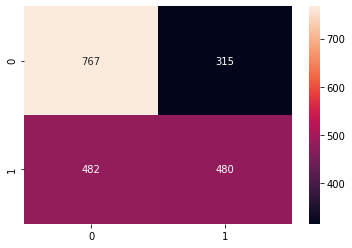

In [9]:
X = n_textos
y = textos[:, 1].astype(np.int).ravel()

clustering = SpectralClustering(
    n_clusters=2,
    eigen_solver="amg",
    assign_labels="discretize",
    affinity="precomputed_nearest_neighbors",
    random_state=0,
    n_jobs=-1
).fit(rbf_kernel(X))

pred = clustering.labels_

print(classification_report(y, pred))

df_cm = confusion_matrix(pred, y)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.show()

### Unsupervised Learning : Doc2Vec +  Spectral Clustering

In [21]:
d2v = Doc2Vec.load(f"{os.getcwd()}/../ai/models/d2v.model")

In [36]:
n_textos = []
for texto in textos:
    doc_vec = d2v.infer_vector(texto[0].split(), epochs=500)
    n_textos.append(doc_vec)
n_textos = np.asarray(n_textos)

In [37]:
validacoes = []

X = n_textos
y = textos[:, 1].astype(np.int).ravel()

for metric in (
    cosine_distances,
    euclidean_distances, 
    rbf_kernel,
    laplacian_kernel, 
):
    for assign_labels in ["discretize", "kmeans"]:
        clustering = SpectralClustering(
            n_clusters=2,
            eigen_solver="amg",
            assign_labels=assign_labels,
            affinity="precomputed_nearest_neighbors",
            random_state=0,
            n_jobs=-1
        ).fit(metric(X))

        pred = clustering.labels_
        acc = round(accuracy_score(pred, y) * 100, 2)
        f1 = round(f1_score(pred, y) * 100, 2)
        vm = round(v_measure_score(y, pred), 2)
        validacoes.append((
            metric.__name__,
            assign_labels,
            acc, 
            f1,
            vm
        ))

In [38]:
columns = ["Metric", "AssignLabels", "Accuracy", "F1", "V-Measure"]
df = pd.DataFrame(validacoes, columns=columns)
df = df.sort_values(by=["F1", "Accuracy", "V-Measure", "Metric"], ascending=False)
df.reset_index().head(25)

,index,Metric,AssignLabels,Accuracy,F1,V-Measure
0,4,rbf_kernel,discretize,54.31,58.45,0.03
1,6,laplacian_kernel,discretize,52.98,56.42,0.02
2,7,laplacian_kernel,kmeans,51.37,19.19,0.01
3,5,rbf_kernel,kmeans,47.02,17.64,0.03
4,0,cosine_distances,discretize,60.37,2.41,0.00
5,1,cosine_distances,kmeans,60.42,1.46,0.00
6,2,euclidean_distances,discretize,60.32,0.98,0.00
7,3,euclidean_distances,kmeans,60.32,0.98,0.00


              precision    recall  f1-score   support

           0       0.77      0.36      0.49      1249
           1       0.45      0.83      0.58       795

    accuracy                           0.54      2044
   macro avg       0.61      0.59      0.54      2044
weighted avg       0.64      0.54      0.53      2044



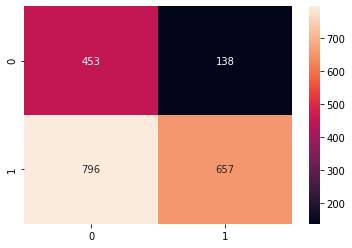

In [39]:
X = n_textos
y = textos[:, 1].astype(np.int).ravel()

clustering = SpectralClustering(
    n_clusters=2,
    eigen_solver="amg",
    assign_labels="discretize",
    affinity="precomputed_nearest_neighbors",
    random_state=0,
    n_jobs=-1
).fit(rbf_kernel(X))

pred = clustering.labels_

print(classification_report(y, pred))

df_cm = confusion_matrix(pred, y)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.show()

### Unsupervised Learning : Doc2Vec +  SOM

In [40]:
def classify(som, data, class_assignments):
    """Classifies each sample in data in one of the classes definited
    using the method labels_map.
    Returns a list of the same length of data where the i-th element
    is the class assigned to data[i].
    """
    winmap = class_assignments
    default_class = np.sum(list(winmap.values())).most_common()[0][0]
    result = []
    for d in data:
        win_position = som.winner(d)
        if win_position in winmap:
            result.append(winmap[win_position].most_common()[0][0])
        else:
            result.append(default_class)
    return result

In [44]:
X = n_textos
y = textos[:, 1].astype(np.int).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

som = MiniSom(150, 150, 300, activation_distance="cosine", sigma=1e-1, learning_rate=1e-3)
som.pca_weights_init(X_train)
som.train_random(X_train, 1000)

              precision    recall  f1-score   support

           0       0.62      1.00      0.77       255
           1       0.00      0.00      0.00       154

    accuracy                           0.62       409
   macro avg       0.31      0.50      0.38       409
weighted avg       0.39      0.62      0.48       409



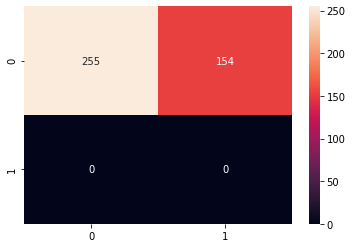

In [45]:
class_assignments = som.labels_map(X_train, y_train)
pred = classify(som, X_test, class_assignments)

print(classification_report(y_test, pred))

df_cm = confusion_matrix(pred, y_test)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.show()

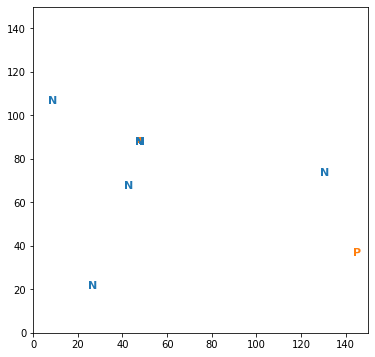

In [46]:
plt.figure(figsize=(6, 6))
wmap = {}
im = 0
for x, t in zip(X_test, y_test):
    w = som.winner(x)
    wmap[w] = im
    plt. text(w[0]+.5,  w[1]+.5, "P" if t == 1 else "N",
              color=f"C{t}", fontdict={'weight': 'bold',  'size': 11})
    im = im + 1
plt.axis([0, som.get_weights().shape[0], 0,  som.get_weights().shape[1]])
plt.show()

### Supervised Learning : Doc2Vec + Logistic Regression

              precision    recall  f1-score   support

           0       0.74      0.69      0.71       255
           1       0.54      0.60      0.57       154

    accuracy                           0.66       409
   macro avg       0.64      0.64      0.64       409
weighted avg       0.66      0.66      0.66       409



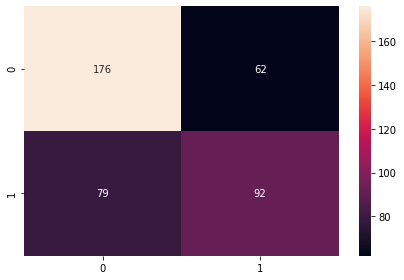

In [47]:
X = n_textos
y = textos[:, 1].astype(np.int).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf = LogisticRegression(
    random_state=0,
    max_iter=100,
    n_jobs=-1
).fit(X_train, y_train)
pred = clf.predict(X_test)

print(classification_report(y_test, pred))

df_cm = confusion_matrix(pred, y_test)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.tight_layout()
plt.show()

### Supervised Learning : Doc2Vec + Ensemble

              precision    recall  f1-score   support

           0       0.77      0.62      0.69       255
           1       0.52      0.70      0.60       154

    accuracy                           0.65       409
   macro avg       0.65      0.66      0.64       409
weighted avg       0.68      0.65      0.65       409



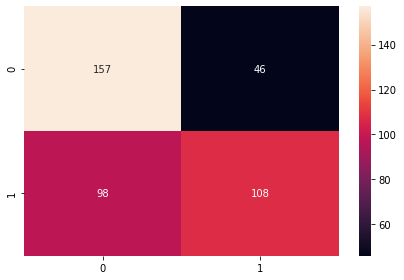

In [48]:
X = n_textos
y = textos[:, 1].astype(np.int).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf1 = LogisticRegression(random_state=0)
clf2 = RandomForestClassifier(n_estimators=150, random_state=0)
clf3 = GaussianNB()

eclf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],
    voting='soft', weights=[2, 2, 1], n_jobs=-1
).fit(X_train, y_train)
pred = eclf.predict(X_test)

print(classification_report(y_test, pred))

df_cm = confusion_matrix(pred, y_test)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.tight_layout()
plt.show()